In [8]:
from numpy import *
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline

In [9]:
# -------------------------------------------------------------------------------
# FIT CIRCLE 2D
# - Find center [xc, yc] and radius r of circle fitting to set of 2D points
# - Optionally specify weights for points
#
# - Implicit circle function:
#   (x-xc)^2 + (y-yc)^2 = r^2
#   (2*xc)*x + (2*yc)*y + (r^2-xc^2-yc^2) = x^2+y^2
#   c[0]*x + c[1]*y + c[2] = x^2+y^2
#
# - Solution by method of least squares:
#   A*c = b, c' = argmin(||A*c - b||^2)
#   A = [x y 1], b = [x^2+y^2]
# -------------------------------------------------------------------------------
def fit_circle_2d(x, y, w=[]):
    A = array([x, y, ones(len(x))]).T
    b = x ** 2 + y ** 2

    # Modify A,b for weighted least squares
    if len(w) == len(x):
        W = diag(w)
        A = dot(W, A)
        b = dot(W, b)

    # Solve by method of least squares
    c = linalg.lstsq(A, b, rcond=None)[0]

    # Get circle parameters from solution c
    xc = c[0] / 2
    yc = c[1] / 2
    r = sqrt(c[2] + xc ** 2 + yc ** 2)
    return xc, yc, r


# -------------------------------------------------------------------------------
# RODRIGUES ROTATION
# - Rotate given points based on a starting and ending vector
# - Axis k and angle of rotation theta given by vectors n0,n1
#   P_rot = P*cos(theta) + (k x P)*sin(theta) + k*<k,P>*(1-cos(theta))
# -------------------------------------------------------------------------------
def rodrigues_rot(P, n0, n1):
    # If P is only 1d array (coords of single point), fix it to be matrix
    if P.ndim == 1:
        P = P[newaxis, :]

    # Get vector of rotation k and angle theta
    n0 = n0 / linalg.norm(n0)
    n1 = n1 / linalg.norm(n1)
    k = cross(n0, n1)
    k = k / linalg.norm(k)
    theta = arccos(dot(n0, n1))

    # Compute rotated points
    P_rot = zeros((len(P), 3))
    for i in range(len(P)):
        P_rot[i] = P[i] * cos(theta) + cross(k, P[i]) * sin(theta) + k * dot(k, P[i]) * (1 - cos(theta))

    return P_rot


# -------------------------------------------------------------------------------
# ANGLE BETWEEN
# - Get angle between vectors u,v with sign based on plane with unit normal n
# -------------------------------------------------------------------------------
def angle_between(u, v, n=None):
    if n is None:
        return arctan2(linalg.norm(cross(u, v)), dot(u, v))
    else:
        return arctan2(dot(n, cross(u, v)), dot(u, v))


# -------------------------------------------------------------------------------
# - Make axes of 3D plot to have equal scales
# - This is a workaround to Matplotlib's set_aspect('equal') and axis('equal')
#   which were not working for 3D
# -------------------------------------------------------------------------------
def set_axes_equal_3d(ax):
    limits = array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    spans = abs(limits[:, 0] - limits[:, 1])
    centers = mean(limits, axis=1)
    radius = 0.5 * max(spans)
    ax.set_xlim3d([centers[0] - radius, centers[0] + radius])
    ax.set_ylim3d([centers[1] - radius, centers[1] + radius])
    ax.set_zlim3d([centers[2] - radius, centers[2] + radius])


# -------------------------------------------------------------------------------
# Generate points on circle
# P(t) = r*cos(t)*u + r*sin(t)*(n x u) + C
# -------------------------------------------------------------------------------
def generate_circle_by_vectors(t, C, r, n, u):
    n = n / linalg.norm(n)
    u = u / linalg.norm(u)
    P_circle = r * cos(t)[:, newaxis] * u + r * sin(t)[:, newaxis] * cross(n, u) + C
    return P_circle


def generate_circle_by_angles(t, C, r, theta, phi):
    # Orthonormal vectors n, u, <n,u>=0
    n = array([cos(phi) * sin(theta), sin(phi) * sin(theta), cos(theta)])
    u = array([-sin(phi), cos(phi), 0])

    # P(t) = r*cos(t)*u + r*sin(t)*(n x u) + C
    P_circle = r * cos(t)[:, newaxis] * u + r * sin(t)[:, newaxis] * cross(n, u) + C
    return P_circle

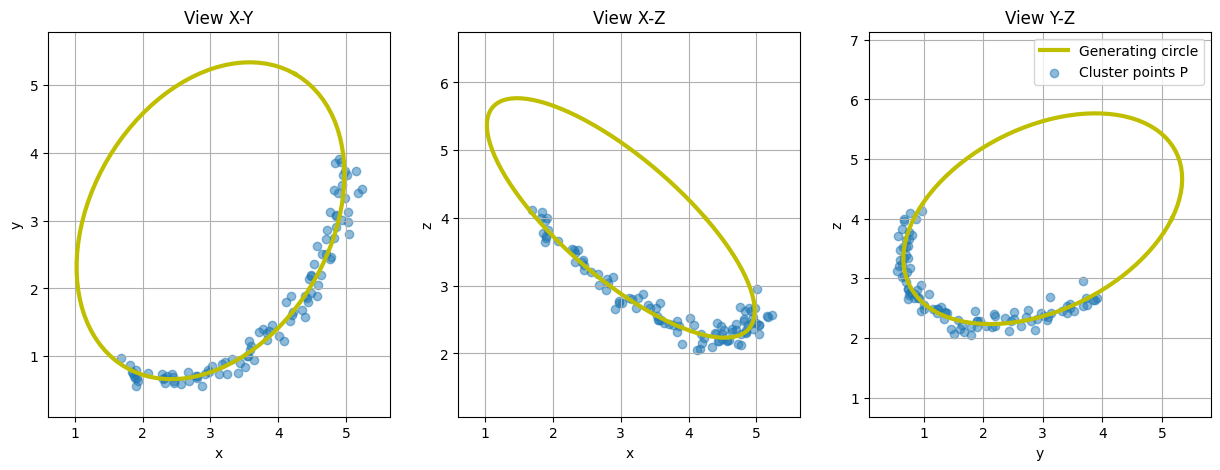

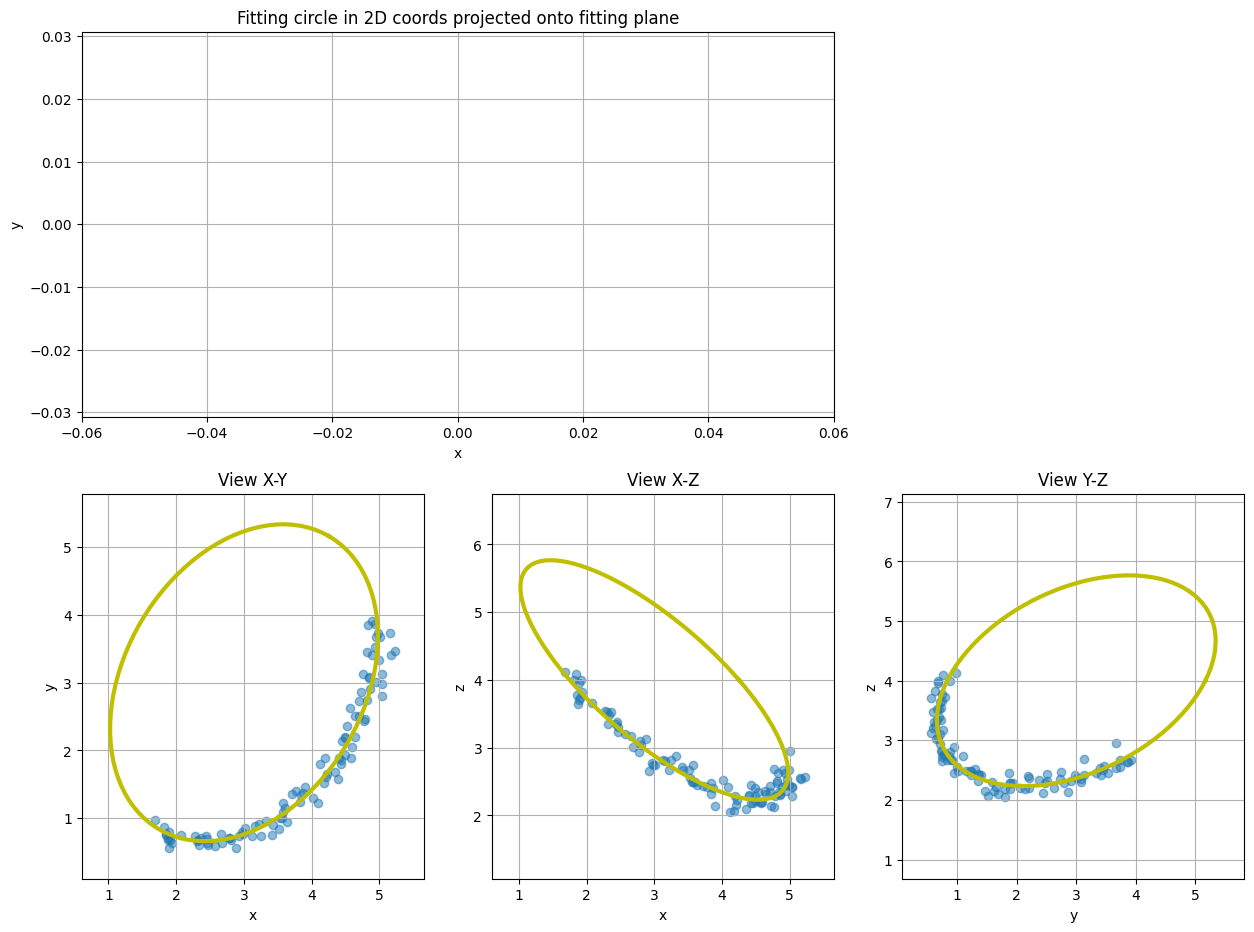

In [10]:
#-------------------------------------------------------------------------------
# Generating circle
#-------------------------------------------------------------------------------
r = 2.5               # Radius
C = array([3,3,4])    # Center
theta = 45/180*pi     # Azimuth
phi   = -30/180*pi    # Zenith

t = linspace(0, 2*pi, 100)
P_gen = generate_circle_by_angles(t, C, r, theta, phi)

#-------------------------------------------------------------------------------
# Cluster of points
#-------------------------------------------------------------------------------
t = linspace(-pi, -0.25*pi, 100)
n = len(t)
P = generate_circle_by_angles(t, C, r, theta, phi)

# Add some random noise to the points
P += random.normal(size=P.shape) * 0.1

#-------------------------------------------------------------------------------
# Plot
#-------------------------------------------------------------------------------
f, ax = subplots(1, 3, figsize=(15,5))
alpha_pts = 0.5
i = 0
ax[i].plot(P_gen[:,0], P_gen[:,1], 'y-', lw=3, label='Generating circle')
ax[i].scatter(P[:,0], P[:,1], alpha=alpha_pts, label='Cluster points P')
ax[i].set_title('View X-Y')
ax[i].set_xlabel('x'); ax[i].set_ylabel('y');
ax[i].set_aspect('equal', 'datalim'); ax[i].margins(.1, .1)
ax[i].grid()
i = 1
ax[i].plot(P_gen[:,0], P_gen[:,2], 'y-', lw=3, label='Generating circle')
ax[i].scatter(P[:,0], P[:,2], alpha=alpha_pts, label='Cluster points P')
ax[i].set_title('View X-Z')
ax[i].set_xlabel('x'); ax[i].set_ylabel('z');
ax[i].set_aspect('equal', 'datalim'); ax[i].margins(.1, .1)
ax[i].grid()
i = 2
ax[i].plot(P_gen[:,1], P_gen[:,2], 'y-', lw=3, label='Generating circle')
ax[i].scatter(P[:,1], P[:,2], alpha=alpha_pts, label='Cluster points P')
ax[i].set_title('View Y-Z')
ax[i].set_xlabel('y'); ax[i].set_ylabel('z');
ax[i].set_aspect('equal', 'datalim'); ax[i].margins(.1, .1)
ax[i].legend()
ax[i].grid()

#-------------------------------------------------------------------------------
# Init figures
#-------------------------------------------------------------------------------
fig = figure(figsize=(15,11))
alpha_pts = 0.5
figshape = (2,3)
ax = [None]*4
ax[0] = subplot2grid(figshape, loc=(0,0), colspan=2)
ax[1] = subplot2grid(figshape, loc=(1,0))
ax[2] = subplot2grid(figshape, loc=(1,1))
ax[3] = subplot2grid(figshape, loc=(1,2))
i = 0
ax[i].set_title('Fitting circle in 2D coords projected onto fitting plane')
ax[i].set_xlabel('x'); ax[i].set_ylabel('y');
ax[i].set_aspect('equal', 'datalim'); ax[i].margins(.1, .1); ax[i].grid()
i = 1
ax[i].plot(P_gen[:,0], P_gen[:,1], 'y-', lw=3, label='Generating circle')
ax[i].scatter(P[:,0], P[:,1], alpha=alpha_pts, label='Cluster points P')
ax[i].set_title('View X-Y')
ax[i].set_xlabel('x'); ax[i].set_ylabel('y');
ax[i].set_aspect('equal', 'datalim'); ax[i].margins(.1, .1); ax[i].grid()
i = 2
ax[i].plot(P_gen[:,0], P_gen[:,2], 'y-', lw=3, label='Generating circle')
ax[i].scatter(P[:,0], P[:,2], alpha=alpha_pts, label='Cluster points P')
ax[i].set_title('View X-Z')
ax[i].set_xlabel('x'); ax[i].set_ylabel('z');
ax[i].set_aspect('equal', 'datalim'); ax[i].margins(.1, .1); ax[i].grid()
i = 3
ax[i].plot(P_gen[:,1], P_gen[:,2], 'y-', lw=3, label='Generating circle')
ax[i].scatter(P[:,1], P[:,2], alpha=alpha_pts, label='Cluster points P')
ax[i].set_title('View Y-Z')
ax[i].set_xlabel('y'); ax[i].set_ylabel('z');
ax[i].set_aspect('equal', 'datalim'); ax[i].margins(.1, .1); ax[i].grid()

Fitting plane: n = [-0.6196  0.3602 -0.6974]
Fitting circle: center = [3.0376 2.9435 3.9808], r = 2.459
Fitting arc: u = [-1.3543 -1.9683  0.141 ], θ = -139.6


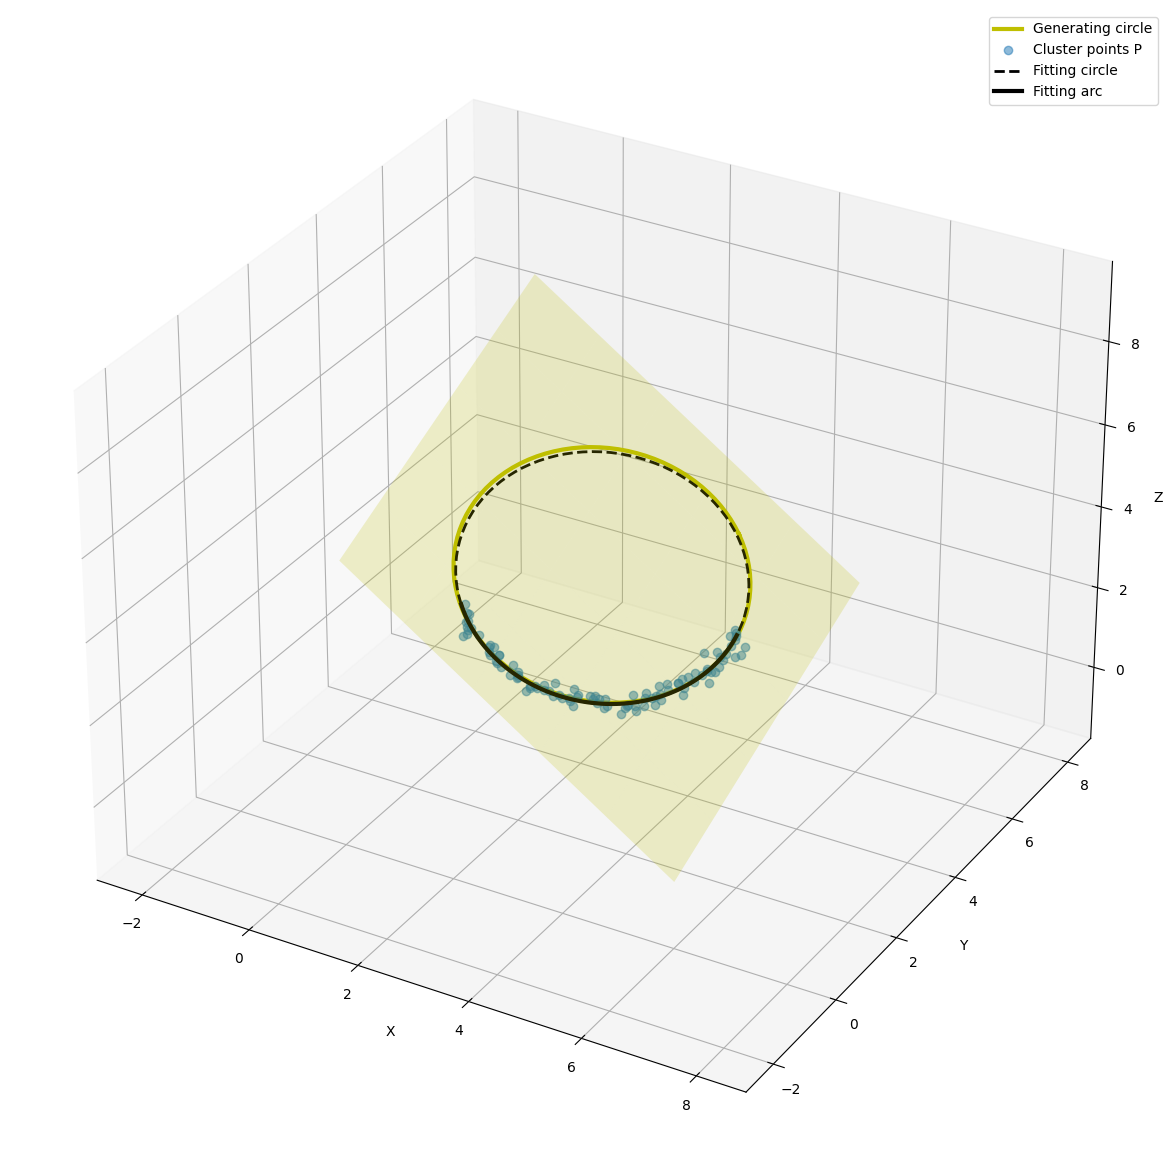

In [11]:
#-------------------------------------------------------------------------------
# (1) Fitting plane by SVD for the mean-centered data
# Eq. of plane is <p,n> + d = 0, where p is a point on plane and n is normal vector
#-------------------------------------------------------------------------------
P_mean = P.mean(axis=0)
P_centered = P - P_mean
U,s,V = linalg.svd(P_centered)

# Normal vector of fitting plane is given by 3rd column in V
# Note linalg.svd returns V^T, so we need to select 3rd row from V^T
normal = V[2,:]
d = -dot(P_mean, normal)  # d = -<p,n>

#-------------------------------------------------------------------------------
# (2) Project points to coords X-Y in 2D plane
#-------------------------------------------------------------------------------
P_xy = rodrigues_rot(P_centered, normal, [0,0,1])

ax[0].scatter(P_xy[:,0], P_xy[:,1], alpha=alpha_pts, label='Projected points')

#-------------------------------------------------------------------------------
# (3) Fit circle in new 2D coords
#-------------------------------------------------------------------------------
xc, yc, r = fit_circle_2d(P_xy[:,0], P_xy[:,1])

#--- Generate circle points in 2D
t = linspace(0, 2*pi, 100)
xx = xc + r*cos(t)
yy = yc + r*sin(t)

ax[0].plot(xx, yy, 'k--', lw=2, label='Fitting circle')
ax[0].plot(xc, yc, 'k+', ms=10)
ax[0].legend()

#-------------------------------------------------------------------------------
# (4) Transform circle center back to 3D coords
#-------------------------------------------------------------------------------
C = rodrigues_rot(array([xc,yc,0]), [0,0,1], normal) + P_mean
C = C.flatten()

#--- Generate points for fitting circle
t = linspace(0, 2*pi, 100)
u = P[0] - C
P_fitcircle = generate_circle_by_vectors(t, C, r, normal, u)

ax[1].plot(P_fitcircle[:,0], P_fitcircle[:,1], 'k--', lw=2, label='Fitting circle')
ax[2].plot(P_fitcircle[:,0], P_fitcircle[:,2], 'k--', lw=2, label='Fitting circle')
ax[3].plot(P_fitcircle[:,1], P_fitcircle[:,2], 'k--', lw=2, label='Fitting circle')
ax[3].legend()

#--- Generate points for fitting arc
u = P[0] - C
v = P[-1] - C
theta = angle_between(u, v, normal)

t = linspace(0, theta, 100)
P_fitarc = generate_circle_by_vectors(t, C, r, normal, u)

ax[1].plot(P_fitarc[:,0], P_fitarc[:,1], 'k-', lw=3, label='Fitting arc')
ax[2].plot(P_fitarc[:,0], P_fitarc[:,2], 'k-', lw=3, label='Fitting arc')
ax[3].plot(P_fitarc[:,1], P_fitarc[:,2], 'k-', lw=3, label='Fitting arc')
ax[1].plot(C[0], C[1], 'k+', ms=10)
ax[2].plot(C[0], C[2], 'k+', ms=10)
ax[3].plot(C[1], C[2], 'k+', ms=10)
ax[3].legend()

print('Fitting plane: n = %s' % array_str(normal, precision=4))
print('Fitting circle: center = %s, r = %.4g' % (array_str(C, precision=4), r))
print('Fitting arc: u = %s, θ = %.4g' % (array_str(u, precision=4), theta*180/pi))

fig = figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(*P_gen.T, color='y', lw=3, label='Generating circle')
ax.plot(*P.T, ls='', marker='o', alpha=0.5, label='Cluster points P')

#--- Plot fitting plane
xx, yy = meshgrid(linspace(0,6,11), linspace(0,6,11))
zz = (-normal[0]*xx - normal[1]*yy - d) / normal[2]
ax.plot_surface(xx, yy, zz, rstride=2, cstride=2, color='y' ,alpha=0.2, shade=False)

#--- Plot fitting circle
ax.plot(*P_fitcircle.T, color='k', ls='--', lw=2, label='Fitting circle')
ax.plot(*P_fitarc.T, color='k', ls='-', lw=3, label='Fitting arc')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

ax.set_aspect('equal', 'datalim')
set_axes_equal_3d(ax)


In [30]:
import numpy as np

def skew(x):
    xx=np.array([[0,-x[2],x[1]],\
                 [x[2],0,-x[0]],\
                 [-x[1],x[0],0]])
    return xx

def outer_product(y,x):
    if y.shape is not (5,1):
        y = y.reshape((5,1))
    if x.shape is not (5,1):
        x = x.reshape((5,1))

    yx=skew(y[:3,0])
    yoi=y[3,0]*np.eye(3)
    yinfi=y[4,0]*np.eye(3)
    A=np.zeros((10,5))
    A[:3,:3]=yx
    A[3:6,0:3]=yoi
    A[3:6,3]=-y[0:3,0]
    A[6:9,0:3]=-yinfi
    A[6:9,4]=y[0:3,0]
    A[9,3]=-y[4,0]
    A[9,4]=y[3,0]
    val=A@x

    return val

def construct_p_from_batch(ps):
    N=ps.shape[0]
    D=np.zeros((5,N))
    for i, p in enumerate(ps):
        D[:3,i]=ps[i,:].T
        D[3,i]=1
        D[4,i]=0.5*np.linalg.norm(ps[i,:])**2
    M=np.block([[np.eye(3),np.zeros((3,2))],\
                [np.zeros((1,4)),-1],\
                [np.zeros((1,3)),-1,0]])
    P2=D@D.T@M
    P2=P2/N
    return P2

def construct_a_single_p(p):
    if p.shape is not (3,1):
        p = p.reshape((3,1))
    P=np.zeros((5,5))
    P[:3,:3]=p@p.T
    pnorm=np.linalg.norm(p)
    P[:3,3]=-0.5*pnorm**2*p.squeeze()
    P[:3,4]=-p.squeeze()
    P[3,:3]=p.T
    P[3,3]=-0.5*pnorm**2
    P[3,4]=-1
    P[4,:3]=0.5*pnorm**2*p.T
    P[4,3]=-0.25*pnorm**4
    P[4,4]=-0.5*pnorm**2

    return P

def recover_circle_parameter(e,verbose=False):
    if e.shape is not (10,):
        e=e.squeeze()
    ei=e[:3]
    eoi=e[3:6]
    einfi=e[6:9]
    eoinf=-e[9]

    alpha=np.linalg.norm(eoi)
    n1=-eoi/alpha
    n=-eoi

    B0=eoinf
    B1=ei[0]
    B2=ei[1]
    B3=ei[2]
    
    c=np.array([[B0,-B3,B2],\
                [B3,B0,-B1],\
                [-B2,B1,B0]])@n.reshape((3,1))/(np.linalg.norm(n)**2)
    c=c.squeeze()

    radius_square=np.linalg.norm(c)**2-2*n1.dot(einfi)/alpha-2*(c.dot(n1))**2
    radius=np.sqrt(radius_square)
    return (c,radius,n1)

def lsq_fit_3d_circle(points, verbose=False):
    if points.shape[0] < points.shape[1]:
        points=points.T

    M=construct_p_from_batch(points)

    evals,evecs=np.linalg.eig(M)

    indx=np.argsort(evals)
    indx1 = (evals[indx]>0).nonzero()[0]

    sol1=evecs[:,indx[indx1[0]]]
    sol2=evecs[:,indx[indx1[1]]]

    sol_final=outer_product(sol2,sol1)
    if verbose is True:
        print(sol_final)

    center, radius, normal=recover_circle_parameter(sol_final,verbose)

    return {'center':center,'radius':radius}

<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:45: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:62: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:45: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:62: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/_9/mh7_58rs1lsctvdw24smhxrm0000gn/T/ipykernel_18480/2586173290.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if y.shape is not (5,1):
/var/folders/_9/mh7_58rs1lsctvdw24smhxrm0000gn/T/ipykernel_18480/2586173290.py:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if x.shape is not (5,1):
/var/folders/_9/mh7_58rs1lsctvdw24smhxrm0000gn/T/ipykernel_18480/2586173290.py:45: SyntaxWarning: "is not" with a literal. Did you mea

In [31]:
lsq_fit_3d_circle(P, verbose = True)
# Fitting circle: center = [3.0376 2.9435 3.9808], r = 2.459
# Fitting arc: u = [-1.3543 -1.9683  0.141 ], θ = -139.6

# r = 2.5               # Radius
# C = array([3,3,4])    # Center

# for p in P:
    # print("{},{},{},".format(p[0],p[1],p[2]))

 # 15.0547  7.41116  9.70905 -54.5646 -3.73051
 # 7.41116  4.07335  4.40018 -28.1817 -1.72235
 # 9.70905  4.40018  7.76597 -35.5108 -2.73458
 # 3.73051  1.72235  2.73458  -13.447       -1
 # 54.5646  28.1817  35.5108 -204.008  -13.447


[[ 0.06092507]
 [ 0.00676014]
 [-0.0506211 ]
 [ 0.01067859]
 [-0.006207  ]
 [ 0.01202332]
 [ 0.03801593]
 [ 0.27192487]
 [ 0.08206803]
 [ 0.06202432]]


{'center': array([3.01312627, 2.98902903, 4.02561778]),
 'radius': 2.517269243826047}